In [9]:
import tensorflow as tf
import numpy as np
import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display

In [15]:
#A funcion for displaying the state of the pond's surface as an image
def displayArray(a, fmt='jpeg', rng=[0,1]):
    a = (a-rng[0])/float(rng[1]- rng[0])*255
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    clear_output(wait = True)
    display(Image(data=f.getvalue()))

In [16]:
sess = tf.InteractiveSession()

In [17]:
#Computational Covariance functions
def make_kernel(a):
    #Transform a 2D array into a convolution kernel
    a = np.asarray(a)
    a = a.reshape(list(a.shape)+ [1,1])
    return tf.constant(a, dtype=1)

def simple_conv(x, k):
    # simplified covolution operation
    x = tf.expand_dims(tf.expand_dims(x,0), -1)
    y = tf.nn.depthwise_conv2d(x, k, [1,1,1,1], padding='SAME')
    return y[0, :, :, 0]

def laplace(x):
    #2D laplacian of an array
    laplace_k = make_kernel([[0.5, 1.0, 0.5],
                            [1.0, -6, 1.0],
                            [0.5, 1.0, 0.5]])
    return simple_conv(x, laplace_k)

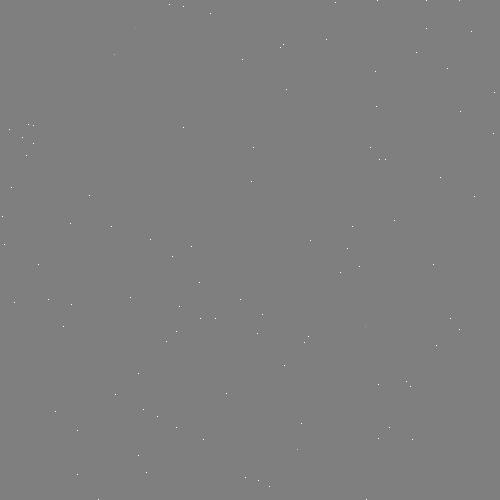

In [19]:
#Creating pond with 500x500 square 
N = 500
#Setting everything to zero
u_init = np.zeros([N,N], dtype = np.float32)
ut_init = np.zeros([N,N], dtype = np.float32)
#some rain drops
for n in range(100):
    a, b = np.random.randint(0, N,2)
    u_init[a,b] = np.random.uniform()
displayArray(u_init, rng=[-0.1, 0.1])


In [20]:
#details of differenctial equation
eps = tf.placeholder(tf.float32, shape=())#time resolution
damping = tf.placeholder(tf.float32, shape=())# wave damping

#Simulation state
U = tf.Variable(u_init)
Ut = tf.Variable(ut_init)

U_ = U +eps*Ut
Ut_ = Ut +eps*(laplace(U) - damping*Ut)

step = tf.group(U.assign(U_), Ut.assign(Ut_))

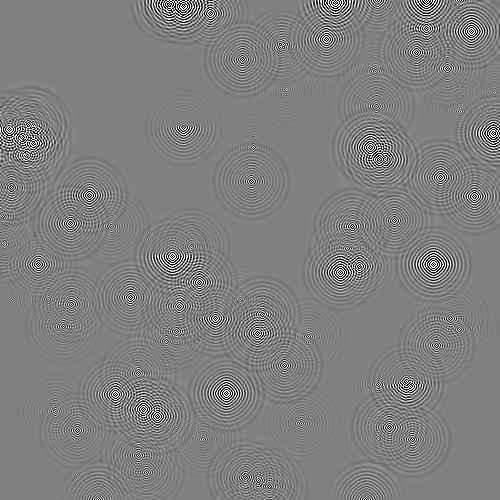

In [21]:
#Running the simulation
tf.global_variables_initializer().run()
for i in range(1000):
    step.run({eps:0.03, damping: 0.04})
    displayArray(U.eval(), rng=[-0.1, 0.1])